## Audio Compression and Preprocessing

Import libraries

In [1]:
import scipy.io.wavfile as wav
import numpy as np
import os

Inspect the WAV file sample data

In [2]:
sample_rate, data = wav.read("Sound1.wav")
print("Sound1.wav file metadata:")
print("Data type:", data.dtype)
print("Min value:", data.min())
print("Max value:", data.max())

Sound1.wav file metadata:
Data type: int16
Min value: -7416
Max value: 7897


In [4]:
sample_rate, data = wav.read("Sound2.wav")
print("Sound2.wav file metadata:")
print("Data type:", data.dtype)
print("Min value:", data.min())
print("Max value:", data.max())

Sound2.wav file metadata:
Data type: int16
Min value: -32768
Max value: 32767


**Rice encoding and decoding functions**

In [5]:
# Function for Rice encode an integer S using parameter K.
def rice_encode(S, K):
    """
    Steps from Coursera Exercise 1.7:
      1. Compute M = 2^K.
      2. Calculate quotient q = S // M and remainder r = S % M.
      3. Encode q in unary: q ones followed by a '0'.
      4. Encode r in binary with fixed width K.
      5. Concatenate the unary and binary codes.

    Args:
      S (int): The integer value to be encoded.
      K (int): The fixed bit-length for the remainder.

    Returns:
      str: The Rice-coded bit string.
    """
    M = 2 ** K
    q = S // M
    r = S % M

    # Unary encoding: q ones followed by a terminating 0
    quotient_code = '1' * q + '0'

    # Remainder code: r as a binary string, padded to K bits.
    remainder_code = format(r, f'0{K}b')

    # The codeword is the concatenation of the quotient code and the remainder code.
    codeword = quotient_code + remainder_code
    return codeword


# Function for Rice decode a given bit string using parameter K.
def rice_decode(codeword, K):
    """
    Steps from Coursera Exercise 1.7:
      1. Count the number of 1s until the first 0. That count is q.
      2. Read the next K bits as a binary number, which is the remainder r.
      3. Calculate the original number as S = q * 2^K + r.

    Args:
      codeword (str): The Rice-coded bit string.
      K (int): The fixed bit-length used during encoding.

    Returns:
      int: The decoded integer S.
    """
    # Count the number of 1s before the first 0 (the unary part).
    q = 0
    index = 0
    while index < len(codeword) and codeword[index] == '1':
        q += 1
        index += 1

    # The first 0 marks the end of the unary code.
    # Skip the 0
    index += 1

    # Read the next K bits for the remainder.
    remainder_bits = codeword[index:index + K]
    r = int(remainder_bits, 2) if remainder_bits else 0

    # Calculate S using the formula
    M = 2 ** K
    S = q * M + r
    return S


test the encode and decode function


In [45]:
K = 4
assert (
    rice_decode(rice_encode(23, K), K) == 23
    and rice_decode("1100011", K) == 35
), "Rice coding test failed!"

print("All tests passed!")

All tests passed!


Helper functions

In [7]:
# Function to convert a bit string to a bytes object
def bits_to_bytes(bit_string):
    # Pad the bit string if necessary to ensure its length is a multiple of 8.
    extra_bits = len(bit_string) % 8
    if extra_bits:
        padding = 8 - extra_bits
        bit_string += '0' * padding

    # Convert the padded bit string to an integer, then to a bytes object.
    num_bytes = len(bit_string) // 8
    return int(bit_string, 2).to_bytes(num_bytes, byteorder='big')


# Function to convert a bytes object to its corresponding bit string
def bytes_to_bits(byte_data):
    return ''.join(format(b, '08b') for b in byte_data)

# Calculate the compression percentage given the size of the original and compressed data
def compression_percentage(original_size, compressed_size):
    if original_size == 0:
        return 0.0  # Avoid division by zero.
    comp_percent = ((original_size - compressed_size) / original_size) * 100
    return comp_percent

In [8]:
# Function to decode a continuous bit string into a list of samples.
def rice_decode_stream(bit_string, K):
    """
    Returns: A list of decoded integer samples.
    """
    decoded_samples = []
    index = 0
    total_length = len(bit_string)

    while index < total_length:
        # Count ones until the first 0 to determine the quotient q
        q = 0
        while index < total_length and bit_string[index] == '1':
            q += 1
            index += 1

        # If reaching the end without finding a 0, break
        if index >= total_length:
            break

        # Skip the 0 that terminates the unary code
        index += 1

        # Extract the next K bits for the remainder
        if index + K > total_length:
            break
        remainder_bits = bit_string[index:index + K]
        r = int(remainder_bits, 2)
        index += K

        sample = q * (2 ** K) + r
        decoded_samples.append(sample)

    return decoded_samples

Encode and Decode audio files

In [9]:
# Encode a WAV audio file using rice coding
def encode_audio_file(input_wav_path, output_ex2_path, K):
    """
    Steps:
      1. Read the WAV file.
      2. Compute offset = -min_value if min_value < 0 (else 0).
      3. Add offset to each sample to make them non-negative.
      4. Rice encode each adjusted sample.
      5. Convert the concatenated bit string to bytes.
      6. Create a header with K, sample rate, num_samples, and offset.
      7. Write header and binary data to the output file.
    """
    # Read the audio file.
    sample_rate, data = wav.read(input_wav_path)

    # If stereo or multi-channel, use one channel (the first channel)
    if len(data.shape) > 1:
        data = data[:, 0]

    # Ensure data is a 1D integer array.
    data = data.flatten()

    # Compute dynamic offset: shift data so that the minimum becomes 0.
    min_value = int(data.min())
    offset = -min_value if min_value < 0 else 0

    # Encode each sample after adding the offset.
    encoded_bits = ""
    for sample in data:
        adjusted_sample = int(sample) + offset
        encoded_bits += rice_encode(adjusted_sample, K)

    # Convert the bit string to bytes.
    encoded_bytes = bits_to_bytes(encoded_bits)

    # Create a header with metadata including the offset.
    header_lines = [
        f"K={K}",
        f"sample_rate={sample_rate}",
        f"num_samples={len(data)}",
        f"offset={offset}",
        "----"  # Delimiter between header and binary data.
    ]
    header_str = "\n".join(header_lines) + "\n"
    header_bytes = header_str.encode('utf-8')

    # Write the header and encoded bytes to the output file.
    with open(output_ex2_path, "wb") as f:
        f.write(header_bytes)
        f.write(encoded_bytes)

    print("Encoding complete.")
    original_size = os.path.getsize(input_wav_path)
    compressed_size = os.path.getsize(output_ex2_path)
    print("Original file size (bytes):", original_size)
    print("Compressed file size (bytes):", compressed_size)
    print("Compression Percentage: {:.2f}%".format(compression_percentage(original_size, compressed_size)))


# Function to decode a Rice-coded file back to a WAV audio file
def decode_audio_file(input_ex2_path, output_wav_path):
    """
    Steps:
      1. Read the encoded file and split the header from the binary data.
      2. Parse the header to extract K, sample rate, num_samples, and offset.
      3. Convert the binary data (bytes) back to a bit string.
      4. Rice decode the bit string to retrieve adjusted samples.
      5. Subtract the stored offset from each sample to recover the original signed value.
      6. Write the reconstructed audio data to a new WAV file.
    """
    with open(input_ex2_path, "rb") as f:
        file_content = f.read()

    # Split header and binary data.
    header_str, encoded_bytes = file_content.split(b"----\n", 1)
    header_lines = header_str.decode('utf-8').strip().split("\n")
    header_info = {}
    for line in header_lines:
        key, value = line.split("=")
        header_info[key.strip()] = value.strip()

    # Extract metadata from header.
    K = int(header_info.get("K"))
    sample_rate = int(header_info.get("sample_rate"))
    num_samples = int(header_info.get("num_samples"))
    offset = int(header_info.get("offset"))

    # Convert the encoded bytes back to a bit string.
    encoded_bits = bytes_to_bits(encoded_bytes)

    # Decode the bit stream to retrieve the adjusted (non-negative) samples.
    decoded_samples = rice_decode_stream(encoded_bits, K)

    # Ensure the decoded sample list has the correct length.
    if len(decoded_samples) > num_samples:
        decoded_samples = decoded_samples[:num_samples]
    elif len(decoded_samples) < num_samples:
        decoded_samples.extend([0] * (num_samples - len(decoded_samples)))

    # Subtract the offset to revert to the original signed values.
    original_samples = [s - offset for s in decoded_samples]

    # Convert to a NumPy array with appropriate data type.
    decoded_array = np.array(original_samples, dtype=np.int16)

    # Write the reconstructed audio data to a WAV file.
    wav.write(output_wav_path, sample_rate, decoded_array)

    print("Decoding complete. Output written to", output_wav_path)


**Preprocessing the audio files with rice encoding**

**When k = 2 bits**

In [10]:
K = 2

In [ ]:
# Encode a first WAV file.
input_wav = "Sound1.wav"
output_ex2 = "Sound1_k2_Enc.ex2"
encode_audio_file(input_wav, output_ex2, K)

# Decode the encoded file back to WAV.
output_wav = "Sound1_k2_Enc_Dec.wav"
decode_audio_file(output_ex2, output_wav)

Encoding complete.
Original file size (bytes): 1002088
Compressed file size (bytes): 116277659
Compression Percentage: -11503.54%
Decoding complete. Output written to Sound1_k2_Enc_Dec.wav


In [12]:
# Encode a second WAV file.
input_wav = "Sound2.wav"
output_ex2 = "Sound2_k2_Enc.ex2"
encode_audio_file(input_wav, output_ex2, K)

# Decode the encoded file back to WAV.
output_wav = "Sound2_k2_Enc_Dec.wav"
decode_audio_file(output_ex2, output_wav)

Encoding complete.
Original file size (bytes): 1008044
Compressed file size (bytes): 517602560
Compression Percentage: -51247.22%
Decoding complete. Output written to Sound2_k2_Enc_Dec.wav


**When k = 4 bits**

In [ ]:
K = 4

In [ ]:
# Encode a first WAV file.
input_wav = "Sound1.wav"
output_ex2 = "Sound1_k4_Enc.ex2"
encode_audio_file(input_wav, output_ex2, K)

# Decode the encoded file back to WAV.
output_wav = "Sound1_k4_Enc_Dec.wav"
decode_audio_file(output_ex2, output_wav)

Encoding complete.
Original file size (bytes): 1002088
Compressed file size (bytes): 29311736
Compression Percentage: -2825.07%
Decoding complete. Output written to Sound1_k4_Enc_Dec.wav


In [ ]:
# Encode a second WAV file.
input_wav = "Sound2.wav"
output_ex2 = "Sound2_k4_Enc.ex2"
encode_audio_file(input_wav, output_ex2, K)

# Decode the encoded file back to WAV.
output_wav = "Sound2_k4_Enc_Dec.wav"
decode_audio_file(output_ex2, output_wav)

Encoding complete.
Original file size (bytes): 1008044
Compressed file size (bytes): 129644844
Compression Percentage: -12761.03%
Decoding complete. Output written to Sound2_k4_Enc_Dec.wav


Check whether the original and decoded audio files are identical

In [14]:
def compare_audio_files(original_wav, decoded_wav):
    # Read both audio files.
    sample_rate_orig, data_orig = wav.read(original_wav)
    sample_rate_dec, data_dec = wav.read(decoded_wav)

    # Compare sample rates.
    if sample_rate_orig != sample_rate_dec:
        print("Sample rates differ!")
        return False

    # Compare array shapes (number of samples/channels).
    if data_orig.shape != data_dec.shape:
        print("Audio dimensions differ!")
        return False

    # Compare the audio data.
    if np.array_equal(data_orig, data_dec):
        print("The decoded audio is identical to the original.")
        return True
    else:
        print("The decoded audio differs from the original.")
        # Optionally, compute the difference:
        diff = np.abs(data_orig - data_dec)
        print("Max difference:", np.max(diff))
        return False


if __name__ == "__main__":
    sound1_original_file = "Sound1.wav"
    sound1_k4_decoded_file = "Sound1_k4_Enc_Dec.wav"
    sound1_k2_decoded_file = "Sound1_k2_Enc_Dec.wav"
    sound2_original_file = "Sound2.wav"
    sound2_k4_decoded_file = "Sound2_k4_Enc_Dec.wav"
    sound2_k2_decoded_file = "Sound1_k2_Enc_Dec.wav"

    print("Check audio files compressed with 2 bits:-----------------------")
    print("Check Sound1.wav:")
    compare_audio_files(sound1_original_file, sound1_k2_decoded_file)
    print("Check Sound2.wav:")
    compare_audio_files(sound2_original_file, sound2_k2_decoded_file)

    print("Check audio files compressed with 4 bits:-----------------------")
    print("Check Sound1.wav:")
    compare_audio_files(sound1_original_file, sound1_k4_decoded_file)
    print("Check Sound2.wav:")
    compare_audio_files(sound2_original_file, sound2_k4_decoded_file)

Check audio files compressed with 2 bits:-----------------------
Check Sound1.wav:
The decoded audio is identical to the original.
Check Sound2.wav:
Audio dimensions differ!
Check audio files compressed with 4 bits:-----------------------
Check Sound1.wav:
The decoded audio is identical to the original.
Check Sound2.wav:
The decoded audio is identical to the original.


**Further Implementation: Rice coding + Run-length encoding (RLE)**

Explore how K param affects the compression ratio

100%|██████████| 11/11 [02:50<00:00, 15.47s/it]


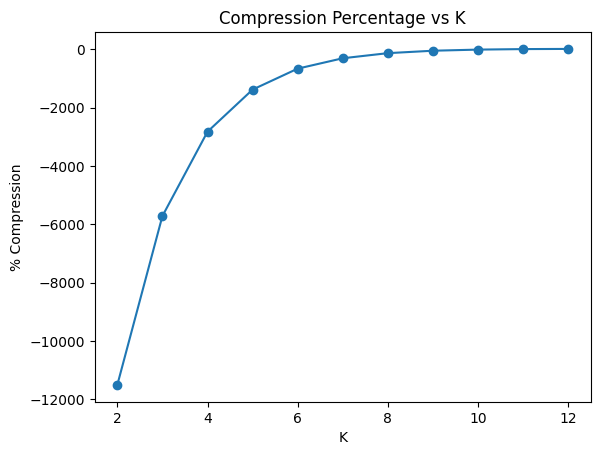

In [13]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to compute the size of the Rice-coded output for a WAV file
# and parameter K, without writing the output to disk.
def compute_encoded_size(input_wav_path, K):
    """
    Steps:
      1. Read the WAV file and extract one channel of data.
      2. Compute a dynamic offset to convert signed samples to non-negative.
      3. Rice encode each sample (after applying the offset).
      4. Convert the resulting bit string to bytes.
      5. Return the byte length.
    """
    # Read audio data
    sample_rate, data = wav.read(input_wav_path)
    if len(data.shape) > 1:
        data = data[:, 0]
    data = data.flatten()

    # Compute dynamic offset
    min_value = int(data.min())
    offset = -min_value if min_value < 0 else 0

    # Rice encode each sample (after applying the offset)
    encoded_bits = ""
    for sample in data:
        adjusted_sample = int(sample) + offset
        encoded_bits += rice_encode(adjusted_sample, K)

    # Convert the bit string to bytes
    encoded_bytes = bits_to_bytes(encoded_bits)
    return len(encoded_bytes)

# Define the range of K values (from 2 to 12)
Ks = range(2, 13)
results = []

# Get the original file size
original_size = os.path.getsize("Sound1.wav")

# Loop over K values and compute the compression percentage
for k in tqdm(Ks):
    encoded_size = compute_encoded_size("Sound1.wav", k)
    comp_percentage = (1 - encoded_size / original_size) * 100
    results.append([k, comp_percentage])

results = np.array(results)

# Plotting the results
plt.title('Compression Percentage vs K')
plt.xlabel('K')
plt.ylabel('% Compression')
plt.plot(results[:, 0], results[:, 1], marker='o')
plt.show()


Based on your plot, it appears that as K increases from 2 up to 8, the compression percentage improves, but beyond K = 8 the gains plateau. Therefore, **K=8** is an optimal choice for rice coding in terms of compression ratio.

In [25]:
# Function to encode a bit string using RLE
# The encoding format for each run is "bit:count" with runs separated by commas.
# Example: "0001110000" becomes "0:3,1:3,0:4".
def rle_encode(bit_string):
    """
    Args: bit_string (str): A string containing only 0s and 1s.

    Returns: str: The RLE-encoded string.
    """
    if not bit_string:
        return ""

    encoded_runs = []
    current_bit = bit_string[0]
    count = 1

    for bit in bit_string[1:]:
        if bit == current_bit:
            count += 1
        else:
            encoded_runs.append(f"{current_bit}:{count}")
            current_bit = bit
            count = 1
    encoded_runs.append(f"{current_bit}:{count}")

    return ",".join(encoded_runs)


# Function to decode an RLE-encoded bit string back to the original bit string.
def rle_decode(rle_string):
    """
    Args: rle_string (str): The RLE-encoded string.

    Returns: str: The decoded bit string.
    """
    if not rle_string:
        return ""

    decoded_bits = []
    runs = rle_string.split(",")
    for run in runs:
        bit, count_str = run.split(":")
        decoded_bits.append(bit * int(count_str))
    return "".join(decoded_bits)

test the encode and decode function

In [27]:
assert rle_decode(rle_encode("1110001100")) == "1110001100"
print("Test passed!")

Test passed!


In [32]:
# Function to encode a WAV file using rice + rle
def encode_audio_file_with_rle(input_wav_path, output_ex2_path, K):
    """
    Steps:
      1. Read the WAV file, select one channel if necessary, and flatten the data.
      2. Compute a dynamic offset so that the minimum sample becomes zero.
      3. For each sample, add the offset and apply Rice encoding (with parameter K).
      4. Concatenate all codewords into one long Rice-coded bit stream.
      5. Apply RLE encoding to the Rice-coded bit stream.
      6. Create a header containing metadata: K, sample_rate, num_samples, offset, and an RLE flag.
      7. Write the header and the RLE-encoded data (as text) to the output file.
    """
    # Read the WAV file.
    sample_rate, data = wav.read(input_wav_path)
    if len(data.shape) > 1:
        data = data[:, 0]  # Use the first channel if stereo.
    data = data.flatten()

    # Compute dynamic offset so that all samples are non-negative.
    min_value = int(data.min())
    offset = -min_value if min_value < 0 else 0

    # Rice encode each sample (after applying the offset).
    rice_encoded_bits = ""
    for sample in data:
        adjusted_sample = int(sample) + offset
        rice_encoded_bits += rice_encode(adjusted_sample, K)

    # Now apply RLE encoding to the Rice-coded bit stream.
    rle_encoded_string = rle_encode(rice_encoded_bits)

    # Create a header with metadata.
    header_lines = [
        f"K={K}",
        f"sample_rate={sample_rate}",
        f"num_samples={len(data)}",
        f"offset={offset}",
        f"RLE=1",  # Flag indicating RLE was applied.
        "----"     # Delimiter between header and data.
    ]
    header_str = "\n".join(header_lines) + "\n"

    # Write header and RLE-encoded string to output file.
    with open(output_ex2_path, "w") as f:
        f.write(header_str)
        f.write(rle_encoded_string)

    print("Encoding with RLE complete.")
    original_size = os.path.getsize(input_wav_path)
    compressed_size = os.path.getsize(output_ex2_path)
    print("Original file size (bytes):", original_size)
    print("Compressed file size (bytes):", compressed_size)
    print("Compression Percentage: {:.2f}%".format(compression_percentage(original_size, compressed_size)))


# Function to decode rice + rle compressed file back to a WAV file
def decode_audio_file_with_rle(input_ex2_path, output_wav_path):
    """
    Steps:
      1. Read the encoded file and split the header from the RLE-encoded data.
      2. Parse the header to extract metadata: K, sample_rate, num_samples, and offset.
      3. RLE decode the encoded string to recover the original Rice-coded bit stream.
      4. Rice decode the bit stream (using the optimal K) to retrieve the adjusted samples.
      5. Subtract the stored offset from each sample to recover the original signed values.
      6. Write the reconstructed samples to a new WAV file using the original sample rate.
    """
    with open(input_ex2_path, "r") as f:
        content = f.read()

    # Split the header from the RLE-encoded data using the delimiter.
    header_str, rle_encoded_string = content.split("----\n", 1)
    header_lines = header_str.strip().split("\n")
    header_info = {}
    for line in header_lines:
        key, value = line.split("=")
        header_info[key.strip()] = value.strip()

    # Retrieve metadata from the header.
    K = int(header_info.get("K"))
    sample_rate = int(header_info.get("sample_rate"))
    num_samples = int(header_info.get("num_samples"))
    offset = int(header_info.get("offset"))

    # RLE decode to recover the Rice-coded bit stream.
    rice_encoded_bits = rle_decode(rle_encoded_string)

    # Rice decode the bit stream to retrieve the adjusted samples.
    # Pass num_samples as the third argument.
    decoded_samples = rice_decode_stream(rice_encoded_bits, K, num_samples)

    # Adjust the number of samples if needed.
    if len(decoded_samples) > num_samples:
        decoded_samples = decoded_samples[:num_samples]
    elif len(decoded_samples) < num_samples:
        decoded_samples.extend([0] * (num_samples - len(decoded_samples)))

    # Subtract the offset to recover original signed sample values.
    original_samples = [s - offset for s in decoded_samples]

    # Convert list of samples to a NumPy array with appropriate type.
    decoded_array = np.array(original_samples, dtype=np.int16)

    # Write the reconstructed audio data to a new WAV file.
    wav.write(output_wav_path, sample_rate, decoded_array)

    print("Decoding with RLE complete. Output written to", output_wav_path)

Rice encoding + RLE

In [34]:
K = 8 # Optimal Rice coding parameter

In [33]:
# Encode the first audio file
input_wav = "Sound1.wav"
output_ex2 = "Sound1_Enc_RLE.ex2"
encode_audio_file_with_rle(input_wav, output_ex2, K)

# Decode the encoded file back to a WAV.
decoded_wav = "Sound1_Enc_RLE_Dec.wav"
decode_audio_file_with_rle(output_ex2, decoded_wav)

Encoding with RLE complete.
Original file size (bytes): 1002088
Compressed file size (bytes): 10774528
Compression Percentage: -975.21%
Decoding with RLE complete. Output written to Sound1_Enc_RLE_Dec.wav


In [35]:
# Encode the second audio file
input_wav = "Sound2.wav"
output_ex2 = "Sound2_Enc_RLE.ex2"
encode_audio_file_with_rle(input_wav, output_ex2, K)

# Decode the encoded file back to a WAV.
decoded_wav = "Sound2_Enc_RLE_Dec.wav"
decode_audio_file_with_rle(output_ex2, decoded_wav)

Encoding with RLE complete.
Original file size (bytes): 1008044
Compressed file size (bytes): 12030458
Compression Percentage: -1093.45%
Decoding with RLE complete. Output written to Sound2_Enc_RLE_Dec.wav
